In [42]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy

import torch.distributions as tdist

from ipywidgets import interact

$\newcommand{\elbo}{\mathrm{ELBO}}$
$\newcommand{\kl}{\mathrm{KL}}$
$\newcommand{\set}[1]{ \left\{ #1 \right\}}$
$\def\R{{\mathbb R}}$
$\def\Q{{\mathbb Q}}$
$\def\E{{\mathbb E}}$
$\def\C{{\mathbb C}}$
$\def\N{{\mathbb N}}$
$\def\Z{{\mathbb Z}}$

$\newcommand{\brac}[1]{\left(#1\right)}$
$\newcommand{\abs}[1]{\left|\, #1\,\right|}$
$\newcommand{\p}{\partial}$
$\newcommand{\abrac}[1]{\left\langle #1 \right\rangle}$
$\newcommand{\sqbrac}[1]{\left[ #1 \right]}$
$\newcommand{\st}{\, \, : \,}$
$\newcommand{\supp}{\mathrm{supp}}$
$\newcommand{\norm}[1]{\lVert #1 \rVert}$
$\renewcommand{\d}[1]{\, \mathrm{d}#1 \,}$

# Unit test: Making sure that code works
Will try to do variational inference against toy Gaussian posterior to make sure that the code has intended behaviour. 

We will attempt to approximate the normal distribution 
$$
p(\xi) = \frac{1}{(2\pi)^{d/2} \sqrt{\mathrm{det}(\sigma_0^2I_d)}} e^{\frac{1}{2\sigma_0^2}\sum_{j = 1}^d (\xi_j - \mu_{0j})^2}. 
$$

We shall find a distribution from the following Gaussian family
$$
\mathcal{Q}_{gaussian} = \set{q_{\mu, \sigma}(\xi) = \frac{1}{(2\pi)^{d/2} \sqrt{\mathrm{det}(\sigma^2I_d)}} e^{\frac{1}{2\sigma^2}\sum_{j = 1}^d (\xi_j - \mu_{j})^2} \st \mu \in \R^d, \sigma \in \R_{> 0}}
$$


In this case, we have ELBO given by 
$$
-\elbo(q) = \E_q\sqbrac{\log \frac{q(\xi)}{e^{-\frac{1}{2\sigma_0^2}\sum_j (\xi_j - \mu_{0j})^2}}} = \E_q \log q(\xi) + \frac{1}{2\sigma_0^2} \E_q \sum_j (\xi_j - \mu_{0j})^2
$$

In [ ]:
mu_0 = torch.tensor([0.5, 0.5])
sigma_0 = torch.tensor([0.5])

mu = nn.Parameter(torch.tensor([.1, .9], dtype=torch.float))
logsigma = nn.Parameter(torch.tensor([np.log(0.9)], dtype=torch.float))
lr = 0.00005
optim = torch.optim.Adam([mu, logsigma], lr=lr)
num_epoch = 300000
S = 2000
rec = []
for epoch in range(num_epoch):
    q = tdist.MultivariateNormal(loc=mu, covariance_matrix=torch.eye(2) * torch.exp(2 * logsigma))
    xi = q.rsample((S, ))
    term1 = q.log_prob(xi)
    term2 = torch.sum((xi - mu_0)**2, dim=1) / (2 * sigma_0**2)
    neg_elbo = torch.mean(term1 + term2)
    neg_elbo.backward()
    optim.step()
    
    if epoch % 500 == 0:
        print(f"{epoch}: mu={mu.detach()}, sigma={torch.exp(logsigma).item()}, negelbo={neg_elbo}")
        rec.append(neg_elbo.detach())

plt.plot(rec)

# Experiment 1: Learning 2D standard form posterior with Gaussian Family

We are assuming that our posterior is of the form 
$$
p(\xi_1, \xi_2) = \frac{1}{\overline{Z}_n} \xi_1^{h_1} \xi_2^{h_2} e^{-n \xi_1^{2k_1} \xi_2^{2k_2}}, \quad (\xi_1, \xi_2) \in [0, 1]^2
$$
where $\overline{Z}_n = \int_{[0, 1]^2} \xi_1^{h_1} \xi_2^{h_2} e^{-n \xi_1^{2k_1} \xi_2^{2k_2}} d\xi_1 d\xi_2$ is the normalising constant, a.k.a. the evidence.  

The posterior contours would look like the following:

In [67]:
N = 200
xx, yy = np.meshgrid(np.linspace(0, 1, num=N), np.linspace(0, 1, num=N))


@interact(
    n=(2, 10000),
    k1=(0, 5),
    k2=(0, 5),
    h1=(0, 5),
    h2=(0, 5)
)
def _plot_contour(n=500, k1=2, k2=3, h1=1, h2=2):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    z = np.abs((xx ** h1) * (yy ** h2)) * np.exp(-n * (xx **(2 * k1)) * (yy **(2*k2)))
    normalising_const = np.sum(z) / (N**2)
    
    lambdas = np.array([(h1 + 1) / (2 * k1), (h2 + 1) / (2 * k2)])
    rlct = np.min(lambdas)
    m = np.sum(lambdas == rlct)
    const_term = (
        scipy.special.loggamma(rlct) 
        - np.log(scipy.special.factorial(m -1)) 
        - np.log(2 * k1) - np.log(2 * k2)
    )
    ks = [k1, k2]
    hs = [h1, h2]
    j = np.argmax(lambdas)
    if m < 2:
        const_term -= np.log(-2 * rlct * ks[j] + hs[j] + 1)
    print(
        f"-logZ = {-np.log(normalising_const)}\n"
        f"RLCT  = {rlct}\n"
        f"m     = {m}\n"
        f"const = {const_term}\n"
        f"rlct log(n) - (m - 1) log log n = {rlct * np.log(n) - (m -1) * np.log(np.log(n))}"
    )
    ax.contourf(xx, yy, z / normalising_const, levels=100)
    ax.set_xlabel("$\\xi_1$")
    ax.set_ylabel("$\\xi_2$")

interactive(children=(IntSlider(value=500, description='n', max=10000, min=2), IntSlider(value=2, description=…

Given a variational family $\mathcal{Q}$, we wish to find a variational approximation $\hat{q} \in \mathcal{Q}$ that minimises the KL-divergence $KL(\hat{q} || p(\xi_1, \xi_2)$. Notice though that this is equivalent to maximising the ELBO = Evidence Lower Bound: 
$$
\elbo(q)= -\E_q\sqbrac{n\xi^{2k}} - \E_q \log \frac{q(\xi)}{\xi^h} \\
$$

This can be shown by the following calculation. 
$$
\begin{align*}
  \kl(q||p) 
  &= \E_q\log \frac{q(\xi)}{p(\xi)}\\
  &= \log \overline{Z}_n + \E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2} e^{-n \xi_1^{2k_1} \xi_2^{2k_2}}} \\
  &= \log \overline{Z}_n + \E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2}} + \E_q n \xi_1^{2k_1} \xi_2^{2k_2}\\
\end{align*}
$$
Since $\kl(q||p) \geq 0$, we can bound the log-evidence with 
$$
  \log \overline{Z}_n \geq -\E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2}} - \E_q n \xi_1^{2k_1} \xi_2^{2k_2} =: \elbo(q)
$$

## Gaussian Variational Family
We shall first use a simple Gaussian family of distribution for variational inference. 
$$
\mathcal{Q}_{gaussian} := \set{q_{\mu_1, \mu_2, \sigma}(\xi) = \frac{1}{2\pi \sigma^2} e^{-\frac{1}{2\sigma^2} \sqbrac{(\xi_1 - \mu_1)^2 + (\xi_2 - \mu_2)^2}} \st \mu_1, \mu_2 \in \R, \sigma \in (0, \infty)}
$$

To maximise $\elbo(q)$ for $q \in \mathcal{Q}_{gaussian}$ via gradient descent on the variational parameters $\theta = (\mu_1, \mu_2, \sigma)$, we need unbiased estimate for the gradient $\nabla_{\theta} \elbo(q)$. We can apply the reparametrisation trick to the above gaussian family as follow, for each $j = 1, 2$
 1. We sample noise $\epsilon_j$ independently from $N(0, 1)$. 
 2. Set $\xi_j = \mu_j + \sigma \epsilon_j$. 

This construction implies that $\xi_j \sim N(\mu_j, \sigma^2)$ and $(\xi_1, \xi_2) \sim q_\theta$. We can then estimate the gradient of ELBO as
$$
\begin{align*}
  -\nabla_\theta \elbo(q_\theta) 
  &= \nabla_\theta \E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2}} + \E_q n \xi_1^{2k_1} \xi_2^{2k_2}\\
  &= \nabla_\theta \E_q\log q(\xi) -  \E_q \log(\xi_1^{h_1} \xi_2^{h_2}) + \E_q n \xi_1^{2k_1} \xi_2^{2k_2}
\end{align*}
$$

In [ ]:

n = 500
k = torch.tensor([2, 3])
h = torch.tensor([1, 2])

mu = nn.Parameter(torch.tensor([.1, .9], dtype=torch.float))
logsigma = nn.Parameter(torch.tensor([np.log(0.3)], dtype=torch.float))
lr = 0.0001
optim = torch.optim.Adam([mu, logsigma], lr=lr)
num_epoch = 100000
S = 1000
rec = []
for epoch in range(num_epoch):
    q = tdist.MultivariateNormal(loc=mu, covariance_matrix=torch.eye(2) * torch.exp(2 * logsigma))
    xi = q.rsample((S, ))
    
    term1 = q.log_prob(xi)
    term2 = torch.sum(torch.log(torch.abs(xi)) * h, dim=1)
    term3 = n * torch.prod(xi**(2 * k), dim=1)
    neg_elbo = torch.mean(term1 - term2 + term3)
    neg_elbo.backward()
    optim.step()
    
    if epoch % 500 == 0:
        print(f"{epoch}: mu={np.around(mu.detach(), 2)}, sigma={torch.exp(logsigma).item()}, negelbo={neg_elbo}")
        rec.append(neg_elbo.detach())

plt.plot(rec)


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


Text(0, 0.5, '$\\xi_2$')

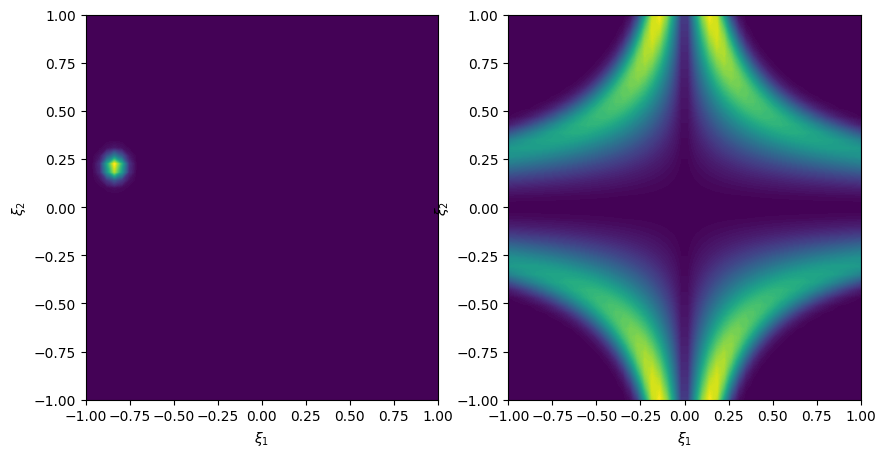

In [78]:
with torch.no_grad():
    sigma = torch.exp(logsigma)
    q = tdist.MultivariateNormal(mu, torch.eye(2) * (sigma**2))
    N = 50
    xx, yy = torch.meshgrid(torch.linspace(-1, 1, steps=50), torch.linspace(-1, 1, steps=50))
    z = q.log_prob(torch.stack((xx, yy), dim=-1))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = axes[0]
ax.contourf(xx, yy, torch.exp(z), levels=100)
ax.set_xlabel("$\\xi_1$")
ax.set_ylabel("$\\xi_2$")


ax = axes[1]
k1, k2 = k
h1, h2 = h
z = np.abs((xx ** h1) * (yy ** h2)) * np.exp(-n * (xx **(2 * k1)) * (yy **(2*k2)))
normalising_const = torch.sum(z) / (N**2)

ax.contourf(xx, yy, z / normalising_const, levels=100)
ax.set_xlabel("$\\xi_1$")
ax.set_ylabel("$\\xi_2$")

# Experiment 2: Learning 2D standard form with Gamma Mean Field Family

## Generalised Gamma Mean Field Family
Our variational family in this case is a mean field family of generalised gamma distributions.
$$
\mathcal{Q}_{gamma} := \set{
q_{\theta}(\xi) = \prod_{j = 1}^2 \frac{2k_j}{\gamma(\lambda_j, \beta_j)} \xi_j^{2k_j \lambda_j -1} e^{-\beta_j \xi_j^{2k_j}} \st \theta = (\lambda_1, \lambda_2, k_1, k_2, \beta_1, \beta_2) \in \R^{3d}_{\geq 0}}
$$

To maximise $\elbo(q)$ for $q \in \mathcal{Q}_{gaussian}$ via gradient descent on the variational parameters $\theta = (\mu_1, \mu_2, \sigma)$, we need unbiased estimate for the gradient $\nabla_{\theta} \elbo(q)$. We can apply the reparametrisation trick to the above gaussian family as follow, for each $j = 1, 2$
 1. We sample noise $\epsilon_j$ independently from $N(0, 1)$. 
 2. Set $\xi_j = \mu_j + \sigma \epsilon_j$. 

This construction implies that $\xi_j \sim N(\mu_j, \sigma^2)$ and $(\xi_1, \xi_2) \sim q_\theta$. We can then estimate the gradient of ELBO as
$$
\begin{align*}
  -\nabla_\theta \elbo(q_\theta) 
  &= \nabla_\theta \E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2}} + \E_q n \xi_1^{2k_1} \xi_2^{2k_2}\\
  &= \nabla_\theta \E_q\log q(\xi) -  \E_q \log(\xi_1^{h_1} \xi_2^{h_2}) + \E_q n \xi_1^{2k_1} \xi_2^{2k_2}
\end{align*}
$$

In [ ]:
n = 500
k = torch.tensor([2, 3])
h = torch.tensor([1, 2])

mu = nn.Parameter(torch.tensor([.1, .9], dtype=torch.float))
logsigma = nn.Parameter(torch.tensor([np.log(0.3)], dtype=torch.float))
lr = 0.0001
optim = torch.optim.Adam([mu, logsigma], lr=lr)
num_epoch = 100000
S = 1000
rec = []
for epoch in range(num_epoch):
    q = tdist.MultivariateNormal(loc=mu, covariance_matrix=torch.eye(2) * torch.exp(2 * logsigma))
    xi = q.rsample((S, ))
    
    term1 = q.log_prob(xi)
    term2 = torch.sum(torch.log(torch.abs(xi)) * h, dim=1)
    term3 = n * torch.prod(xi**(2 * k), dim=1)
    neg_elbo = torch.mean(term1 - term2 + term3)
    neg_elbo.backward()
    optim.step()
    
    if epoch % 500 == 0:
        print(f"{epoch}: mu={np.around(mu.detach(), 2)}, sigma={torch.exp(logsigma).item()}, negelbo={neg_elbo}")
        rec.append(neg_elbo.detach())

plt.plot(rec)


# Experiment 3: Learning 2D standard form with Truncated Generalised Gamma Mean Field Family

# Experiment 4: Learning high dimension standard form, comparing Generalised Gamma Mean Field Family with Gaussian Family